## Driver code comparing output of different atlas / parcellations 

### Steps
- import data csvs 
- visualize data distributions 
- correlate features across pipelines
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [32]:
import sys
import numpy as np
import pandas as pd
import itertools
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [5]:
proj_dir = '/Users/nikhil/code/git_repos/compare-surf-tools/'
data_dir = proj_dir + 'data/'
fs60_dir = data_dir + 'fs60_group_stats/'
demograph_file = 'ABIDE_Phenotype.csv'

#fs60 all files
# Thickness
fs60_aparc_lh_thickness_file = 'lh.aparc.thickness.table.test1'
fs60_aparc_rh_thickness_file = 'rh.aparc.thickness.table.test1' #34 ROIs
fs60_aparc2009_lh_thickness_file = 'lh.aparc.a2009.thickness.table.test1' #74 ROIs per hemi
fs60_aparc2009_rh_thickness_file = 'rh.aparc.a2009.thickness.table.test1'
# Surface Area
fs60_aparc_lh_SA_file = 'aparc_lh_SA_table.test1'
fs60_aparc_rh_SA_file = 'aparc_rh_SA_table.test1'
fs60_aparc2009_lh_SA_file = 'lh.aparc.a2009.SA.table.test1'
fs60_aparc2009_rh_SA_file = 'rh.aparc.a2009.SA.table.test1'


### Global Vars

In [6]:
subject_ID_col = 'SubjID'

### Load data

In [7]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# aparc
aparc = 'aparc'
fs60_aparc_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_lh_thickness_file, delim_whitespace=True)
fs60_aparc_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc data l: {}, r: {}'.format(fs60_aparc_lh_thickness_data.shape,fs60_aparc_rh_thickness_data.shape))
fs60_aparc_thickness_data_std = standardize_fs60_data(fs60_aparc_lh_thickness_data, 
                                                      fs60_aparc_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc_thickness_data_std.shape))


# Destrieux
aparc = 'aparc.a2009s'
fs60_aparc2009_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_lh_thickness_file, delim_whitespace=True)
fs60_aparc2009_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc2009 data l: {}, r: {}'.format(fs60_aparc2009_lh_thickness_data.shape,fs60_aparc2009_rh_thickness_data.shape))
fs60_aparc2009_thickness_data_std = standardize_fs60_data(fs60_aparc2009_lh_thickness_data,
                                                          fs60_aparc2009_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc2009_thickness_data_std.shape))


shape of fs60 aparc data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 aparc data (1047, 71)
shape of fs60 aparc2009 data l: (1047, 76), r: (1047, 76)
shape of left and right merge fs6.0 df (1047, 151)
shape of stdized fs60 aparc data (1047, 151)


In [10]:
fs60_aparc_thickness_data_std.head()

,SubjID,L_bankssts,L_caudalanteriorcingulate,L_caudalmiddlefrontal,L_cuneus,L_entorhinal,L_fusiform,L_inferiorparietal,L_inferiortemporal,L_isthmuscingulate,...,R_rostralmiddlefrontal,R_superiorfrontal,R_superiorparietal,R_superiortemporal,R_supramarginal,R_frontalpole,R_temporalpole,R_transversetemporal,R_insula,rh_MeanThickness_thickness
0,0050002,2.626,2.949,2.830,2.100,3.621,2.779,2.583,2.787,2.492,...,2.684,2.993,2.411,3.054,2.829,2.402,3.770,2.461,3.171,2.66389
1,0050003,2.453,2.804,2.750,1.886,3.347,2.678,2.360,2.571,2.717,...,2.527,3.043,2.182,2.780,2.515,2.820,2.864,2.053,2.695,2.49381
2,0050004,2.635,2.475,2.797,1.930,3.705,2.888,2.644,2.928,2.583,...,2.467,2.985,2.402,3.145,2.686,2.866,4.235,2.446,3.250,2.63965
3,0050006,2.774,2.395,3.054,1.939,3.580,2.802,2.845,3.030,2.532,...,2.881,3.088,2.561,3.269,2.878,2.913,3.768,2.861,3.208,2.79488
4,0050007,2.333,2.575,2.334,2.033,3.184,2.584,2.304,2.523,2.273,...,2.383,2.728,2.169,2.631,2.559,2.599,2.605,2.326,2.812,2.42720


### Create master dataframe

In [22]:
data_dict = {'aparc' : fs60_aparc_thickness_data_std,
            'Destrieux' : fs60_aparc2009_thickness_data_std}

# Add demographic columns to the master_df
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP']].copy()
_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.split('_', 1).str

### Compare ML performance 

In [24]:
outcome_col = 'DX_GROUP'
clf = svm.SVC(kernel='linear')
ml_perf_dict = {}

for atlas in data_dict.keys():
    master_df = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)
    input_cols = master_df.filter(regex='^L|R_', axis=1).columns
    master_df['pipeline'] = np.tile(atlas,len(master_df))
    ml_perf = getClassiferPerf(master_df,input_cols,outcome_col,clf)
    ml_perf_dict[atlas] = ml_perf

Running ML classifer on 1 pipelines
Pipeline aparc,  Accuracy mean:0.540, sd:0.058
Running ML classifer on 1 pipelines
Pipeline Destrieux,  Accuracy mean:0.525, sd:0.058



### Compare statsmodels performance 

In [25]:
covar_cols = ['SEX','AGE_AT_SCAN']
outcome_col = 'DX_GROUP'
stat_model = 'logit'
stat_perf_dict = {}

for atlas in data_dict.keys():
    master_df = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)
    input_cols = master_df.filter(regex='^L|R_', axis=1).columns
    master_df['pipeline'] = np.tile(atlas,len(master_df))
    sm_perf = getStatModelPerf(master_df,input_cols,covar_cols,outcome_col,stat_model)
    stat_perf_dict[atlas] = sm_perf
    print('Shape of the stats_models results df {}'.format(sm_perf.shape))
    

Running 68 mass-univariate logit statsmodels on 1 pipelines
Shape of the stats_models results df (68, 4)
Running 148 mass-univariate logit statsmodels on 1 pipelines
Shape of the stats_models results df (148, 4)


In [27]:
stat_perf_dict['Destrieux']

,roi,pipeline,t_val,p_val
0,L_frontomargin,Destrieux,1.239605,0.215121
1,L_occipital,Destrieux,-0.174815,0.861225
2,L_paracentral,Destrieux,1.081025,0.279686
3,L_subcentral,Destrieux,1.070538,0.284377
4,L_transv,Destrieux,1.386339,0.165643
5,L_cingul-Ant,Destrieux,0.924082,0.355444
6,L_cingul-Mid-Ant,Destrieux,0.830906,0.406027
7,L_cingul-Mid-Post,Destrieux,0.695793,0.486558
8,L_cingul-Post-dorsal,Destrieux,0.883792,0.376809
9,L_cingul-Post-ventral,Destrieux,1.531765,0.125580


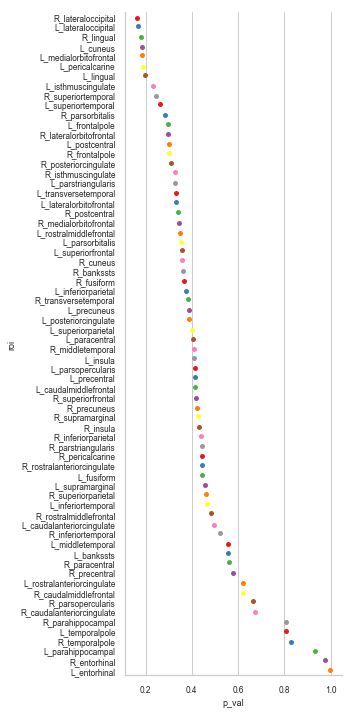

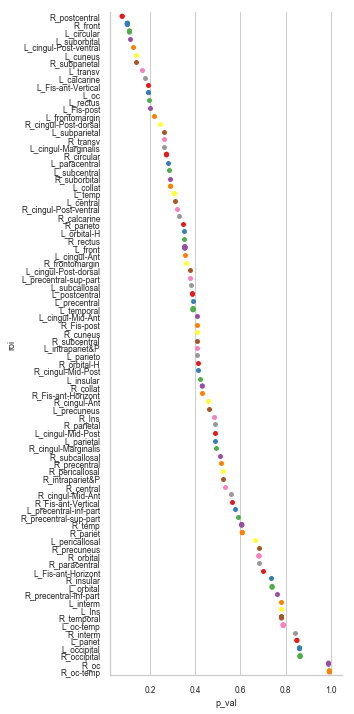

In [36]:
# Plots

plot_df = stat_perf_dict['aparc'].sort_values(by=['p_val'])
sns.set(font_scale=0.75)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='p_val',y='roi',kind='strip',
                    data=plot_df,palette='Set1',height=10,aspect=0.5)
    #g.set(xscale="log");
    
plot_df = stat_perf_dict['Destrieux'].sort_values(by=['p_val'])
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='p_val',y='roi',kind='strip',
                    data=plot_df,palette='Set1',height=10,aspect=0.5)
    #g.set(xscale="log");